In [1]:
import os
import glob
import gzip
import pickle
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from metient.util import plotting_util as putil
from metient.util import vertex_labeling_util as vutil

from metient.util.globals import *

four_dataset_colors = {"Melanoma":"#b84988","HGSOC":"#06879e","HR-NB":"#5a9e09", "NSCLC":"#d4892a"}

REPO_DIR = '/lila/data/morrisq/divyak/projects/metient/metient/'
OUTPUT_DIR = os.path.join(REPO_DIR, 'jupyter_notebooks', 'output_plots')
DATASET_NAMES = ["HGSOC", "Melanoma", "HR-NB", "NSCLC"]
CALIBRATE_DIRS = [
                  os.path.join(REPO_DIR,"data/mcpherson_ovarian_2016/metient_outputs/solve_polys", "calibrate"),
                  os.path.join(REPO_DIR,"data/sanborn_melanoma_2015/metient_outputs_solve_polys_no_cna_pyclone_orchard", "calibrate"),
                  os.path.join(REPO_DIR,"data/gundem_neuroblastoma_2023/metient_outputs/solve_polys", "calibrate"),
                  os.path.join(REPO_DIR,"data/tracerx_nsclc/metient_outputs/tracerx_trees_06252024/calibrate",)]

desired_order = ["single-source", 'multi-source', "reseeding", "primary single-source"]

In [2]:
# Helper functions
def gene_names(item, dataset):
    if dataset == 'HR-NB':
        if str.isdigit(item.split(";")[0]):
            return [item]
        return [item.split(";")[0]]
    elif dataset == 'NSCLC':
        return item.split(";")
    return [item]
    
def update_dict(muts, dct, dataset):
    unique_genes = set()
    for x in muts:
        for y in x:
            genes = gene_names(y, dataset)
            for g in genes:
                unique_genes.add(g)
                
    print("unique_genes", unique_genes)
    for g in unique_genes:
        seeding_muts_to_count = dct[dataset]
        if g not in seeding_muts_to_count:
            seeding_muts_to_count[g] = 0
        seeding_muts_to_count[g] += 1

In [11]:

data = []

dataset_to_seeding_muts_to_count = {d:{} for d in DATASET_NAMES}
dataset_to_nonseeding_muts_to_count = {d:{} for d in DATASET_NAMES}
dataset_to_num_clones = {d:[0,0] for d in DATASET_NAMES}

for calibrate_dir,dataset in zip(CALIBRATE_DIRS, DATASET_NAMES):
    # Use glob to get the list of matching files
    matching_files = glob.glob(f'{calibrate_dir}/*pkl.gz')
    patients = [m.split("/")[-1].split("_")[0] for m in matching_files]
    print(dataset, len(patients))
    for fn in matching_files:
        with gzip.open(fn, 'rb') as f:
            
            pid = fn.split("/")[-1].split("_")[0]
            pkl = pickle.load(f)
            
            # Best calibrated tree
            V = torch.tensor(pkl[OUT_LABElING_KEY][0])
            A = torch.tensor(pkl[OUT_ADJ_KEY][0])
            U = pkl[OUT_OBSERVED_CLONES_KEY]
            losses = [l.item() for l in pkl[OUT_LOSSES_KEY]]
            seeding_clusters = putil.seeding_clusters(V, A)
            primary = pkl[OUT_PRIMARY_KEY]
            sites = pkl[OUT_SITES_KEY]
            idx_to_label = pkl[OUT_IDX_LABEL_KEY][0]
            
            idx_to_label_no_leaves = {}
            nodes_in_primary = []
            for i in idx_to_label:
                if idx_to_label[i][1] == False:
                    labels = idx_to_label[i][0]
                    anat_label = (V[:,i] == 1).nonzero()[0][0].item()
                    if anat_label == sites.index(primary):
                        nodes_in_primary.append(i)
                    assert isinstance(labels, list)
                    for label in labels:
                        if 'pol' in label:
                            parent = vutil.find_parents_children(A, i)[0][0]
                            labels = idx_to_label_no_leaves[parent]
                    idx_to_label_no_leaves[i] = labels
            nonseeding_clusters = [k for k in idx_to_label_no_leaves.keys() if k not in seeding_clusters and k in nodes_in_primary]
            
            dataset_to_num_clones[dataset][0] += len(seeding_clusters)
            dataset_to_num_clones[dataset][1] += len(nonseeding_clusters)
            #print(idx_to_label)
            seeding_muts = [idx_to_label_no_leaves[x] for x in seeding_clusters]
            nonseeding_muts = [idx_to_label_no_leaves[x] for x in nonseeding_clusters]
            print(seeding_muts, nonseeding_muts)
            #print(nonseeding_muts)
            print(pid)
            print("seeding", seeding_clusters)
            update_dict(seeding_muts,dataset_to_seeding_muts_to_count, dataset)
            print("nonseeding", nonseeding_clusters)
            print("nodes_in_primary", nodes_in_primary)
            update_dict(nonseeding_muts, dataset_to_nonseeding_muts_to_count, dataset)
            


HGSOC 13
[['A'], ['B'], ['C'], ['D']] []
7
seeding [0, 1, 2, 3]
unique_genes {'C', 'B', 'A', 'D'}
nonseeding []
nodes_in_primary [0, 1, 2, 3]
unique_genes set()
[['A'], ['B'], ['D'], ['H']] [['E'], ['F'], ['G'], ['I']]
1
seeding [0, 1, 3, 7]
unique_genes {'B', 'H', 'A', 'D'}
nonseeding [4, 5, 6, 8]
nodes_in_primary [0, 1, 3, 4, 5, 6, 7, 8]
unique_genes {'G', 'I', 'E', 'F'}
[['A'], ['B'], ['E'], ['F']] [['C'], ['D']]
10
seeding [0, 1, 4, 5]
unique_genes {'B', 'E', 'A', 'F'}
nonseeding [2, 3]
nodes_in_primary [0, 1, 2, 3, 4, 5]
unique_genes {'C', 'D'}
[['A'], ['B'], ['C'], ['D'], ['F']] [['E']]
3
seeding [0, 1, 2, 3, 5]
unique_genes {'C', 'B', 'A', 'F', 'D'}
nonseeding [4]
nodes_in_primary [0, 1, 2, 3, 4, 5]
unique_genes {'E'}
[['A'], ['B'], ['D'], ['F'], ['H']] []
1
seeding [0, 1, 3, 5, 7]
unique_genes {'B', 'H', 'A', 'F', 'D'}
nonseeding []
nodes_in_primary [0, 1, 3, 5, 7]
unique_genes set()
[['A'], ['B'], ['C'], ['D'], ['F']] []
3
seeding [0, 1, 2, 3, 5]
unique_genes {'C', 'B', 'A', '

[['1;812667', 'ATAD3C;1;1403236', '1;2866890', 'PRDM16;1;3018845', '1;3531470', 'AJAP1;1;4785044', '1;5506093', 'CAMTA1;1;7646485', 'SLC2A5;1;9097161', 'SLC25A33;1;9628977', '1;11819217', 'TNFRSF8;1;12137106', '1;12762906', '1;13794781', 'KAZN;1;14956205', 'TMEM51;1;15544940', '1;17767468', '1;18238732', '1;18339217', '1;20318241', '1;20839212', 'EIF4G3;1;21258159', 'CELA3A;1;22334050', '1;24561558', 'NCMAP;1;24896315', 'NCMAP;1;24935670', '1;25502016', 'MAN1C1;1;26101772', '1;26344300', '1;26970898', '1;27004246', '1;27301937', 'WDTC1;1;27613518', 'WDTC1;1;27613520', 'EYA3;1;28338033', '1;28630268', 'EPB41;1;29237234', '1;30121891', '1;30368986', '1;30577242', '1;35006743', 'GRIK3;1;37465283', 'RP5-884C9.2;1;38516293', '1;38653700', '1;38796780', 'NFYC;1;41235728', '1;42515080', 'IPP;1;46166272', '1;46241161', 'LINC00505;1;46937490', 'MKNK1-AS1;1;47009382', '1;48214274', 'RP4-683M8.2;1;48520692', 'SLC1A7;1;53557146', '1;54997817', 'ACOT11;1;55067324', 'C1orf168;1;57213997', 'DAB1;1;57

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



unique_genes {'ENAM', '4;133281819', 'RP11-661P17.1', '10;66625593', '4;102297530', '12;34059717', 'ZNF385D', '3;115234609', '4;163119778', 'ITGA1', '2;163907053', 'CPD', '19;58958493', '7;109347006', 'VWA8', 'CDK6', '11;118703097', 'AC007193.6', '1;39413411', '19;43806352', 'KMT2C', '16;60965976', 'BICD1', '7;118962493', '4;64939763', '4;156501396', '18;62254735', '5;117121512', '7;151219788', 'AGMO', '12;30973372', 'FNDC3B', '7;27114976', 'RP11-85M11.2', 'EPB41L3', 'SLC25A31', '11;56292888', '13;83921346', 'ZFP37', 'SLC25A12', '7;136129114', '5;84905381', '3;43258540', 'RBFOX1', '7;158941338', 'TACC1P1', '7;16017652', '12;74847848', '16;33531357', 'RP11-38H17.1', '13;68904212', 'CTC-498M16.4', '4;35788284', 'EPHA3', 'CTD-3203P2.2', '5;84309319', '15;75103078', '11;122688354', 'RP11-71H9.1', 'COL25A1', '7;56793890', 'RP11-656G20.1', '3;100858338', 'RP11-499F3.2', '17;78096378', 'UGGT2', '6;101691499', '11;98801564', 'GADL1', '4;171812882', '3;83158754', 'TMEM255B', '13;80498697', 'NPN

[['ERBB2'], ['ATP2B4;CXCR4']] [['COL5A1;UNCX'], ['WT1;SOX9'], ['CREB3L3'], ['ARID1A'], ['TSSC1;GGCX'], ['IL7R;COL5A1'], ['SETBP1;CHD8'], ['RAP1GAP;PIGC'], ['DCAF6;ZNF496'], ['CCT3;CACNA1E'], ['C1QC;RCC1'], ['ST3GAL6;ZIC1'], ['STON1-GTF2A1L;ZRANB3']]
CRUK0557
seeding [2, 15]
unique_genes {'ATP2B4', 'CXCR4', 'ERBB2'}
nonseeding [0, 5, 4, 3, 11, 6, 8, 16, 7, 14, 10, 17, 13]
nodes_in_primary [0, 2, 5, 4, 15, 3, 11, 6, 8, 16, 7, 14, 10, 17, 13]
unique_genes {'CREB3L3', 'TSSC1', 'SOX9', 'ZNF496', 'ZRANB3', 'ZIC1', 'IL7R', 'UNCX', 'ST3GAL6', 'STON1-GTF2A1L', 'CHD8', 'RAP1GAP', 'WT1', 'DCAF6', 'RCC1', 'COL5A1', 'SETBP1', 'GGCX', 'ARID1A', 'PIGC', 'CACNA1E', 'C1QC', 'CCT3'}
[['CHD8;MUC6']] [['COL5A1;EGFR'], ['CHD4;POLE'], ['KEL;HGF'], ['CHD8;RQCD1'], ['HMCN1;PWWP2A'], ['KCNH1;GCKR'], ['ARID2;FLT3'], ['PP2D1;NBEAL2'], ['SPTA1'], ['PLEKHA6;NEB'], ['HDAC4;FLNC'], ['WDR12;CEP135'], ['PPP1R8;DYSF'], ['1;ZNF385D']]
CRUK0589
seeding [4]
unique_genes {'CHD8', 'MUC6'}
nonseeding [0, 5, 1, 2, 8, 7, 6, 13

[['PMS1']] [['KEAP1;ASXL1'], ['INPPL1'], ['STK11'], ['PIP5K1A;ELK4'], ['SPTA1'], ['MDH1;VIL1'], ['MARCH7;TMEM198'], ['MACF1'], ['PLXNB2'], ['OR1C1;SNTG2'], ['NSD1'], ['TOPBP1;EPHB1'], ['TET2;PTCH1'], ['TBL1XR1'], ['ILDR2;GAK'], ['ATR'], ['PKLR;EEF1B2']]
CRUK0667
seeding [2]
unique_genes {'PMS1'}
nonseeding [0, 1, 4, 5, 8, 10, 17, 15, 6, 7, 9, 18, 11, 16, 12, 13, 14]
nodes_in_primary [0, 2, 1, 4, 5, 8, 10, 17, 15, 6, 7, 9, 18, 11, 16, 12, 13, 14]
unique_genes {'GAK', 'ELK4', 'TBL1XR1', 'ATR', 'PIP5K1A', 'EPHB1', 'PKLR', 'NSD1', 'SNTG2', 'EEF1B2', 'KEAP1', 'INPPL1', 'PLXNB2', 'STK11', 'SPTA1', 'PTCH1', 'TMEM198', 'MARCH7', 'VIL1', 'TET2', 'TOPBP1', 'MDH1', 'MACF1', 'OR1C1', 'ASXL1', 'ILDR2'}
[['ALK'], ['CTH;ADAMTS4'], ['TMCO4;TBX15'], ['UNC80;DCP1B'], ['SGCD;GARNL3'], ['ASAP2;E2F6']] [['KEAP1;COL5A1'], ['TP53'], ['FAM183A;RYR2'], ['PXDN;DNAH6'], ['PTPRC'], ['SPAG16;SPEF2'], ['TMEM57;RYR2'], ['PIK3CD;CHRNB3'], ['SP140;PRSS12']]
CRUK0415
seeding [2, 3, 8, 11, 12, 16]
unique_genes {'UNC80',

In [4]:
dataset_to_nonseeding_muts_to_count

{'HGSOC': {'G': 2,
  'I': 1,
  'E': 5,
  'F': 3,
  'C': 3,
  'D': 3,
  'B': 1,
  'A': 2,
  'H': 1},
 'Melanoma': {'PITPNM2': 1,
  'UNC79': 1,
  'TXNDC16': 1,
  'RFXANK': 1,
  'KDM2B': 1,
  'ZNF865': 1,
  'CDH9': 1,
  'GAlymph node metastasis, left groinT10': 1,
  'TRPM1': 1,
  'FBN2': 1,
  'PROM2': 1,
  'MYO15A': 1,
  'ZNF629': 1,
  'TMEM59': 1,
  'ATP10B': 1,
  'UTP15': 1,
  'ZNF267': 1,
  'FBXL7': 2,
  'SLC18A1': 1,
  'SBSN': 1,
  'UBE2O': 1,
  'EXOSC10': 1,
  'NRAS': 2,
  'LILRA2': 1,
  'ZZZ3': 1,
  'PTPRC': 1,
  'MYT1L': 1,
  'TCERG1': 1,
  'MRPL28': 1,
  'MAP3K10': 1,
  'SLC4A9': 1,
  'RERGL': 1,
  'ECI1': 1,
  'ALPK3': 2,
  'GUSB': 1,
  'ERCC8': 1,
  'FZD1': 2,
  'HADHA': 1,
  'MUC20': 1,
  'B3GNT6': 1,
  'SHANK1': 2,
  'RNF148': 1,
  'MESDC1': 1,
  'DNAJC6': 1,
  'ISG20': 1,
  'SPPL2B': 2,
  'ARID1A': 1,
  'CCDC24': 1,
  'NCOA2': 1,
  'DALRD3': 1,
  'SLC5A1': 1,
  'EMG1': 1,
  'LPPR5': 1,
  'FSIP2': 1,
  'TMIGD2': 1,
  'RFPL3': 1,
  'RP1L1': 1,
  'UNC13A': 1,
  'BCL9': 1,
  'SSH

In [5]:
top_genes_per_dataset = {}

for dataset, genes in dataset_to_seeding_muts_to_count.items():
    # Sort genes by count in descending order and get the top 10
    sorted_genes = sorted(genes.items(), key=lambda item: item[1], reverse=True)[:10]
    top_genes_per_dataset[dataset] = dict(sorted_genes)

print(top_genes_per_dataset)

{'HGSOC': {'A': 11, 'B': 10, 'C': 7, 'D': 7, 'F': 4, 'H': 2, 'E': 1}, 'Melanoma': {'LOXHD1': 3, 'ASXL3': 3, 'DSEL': 3, 'DCC': 3, 'NOL4': 2, 'ZNF516': 2, 'AMPD1': 2, 'SERPINB2': 2, 'APOB': 2, 'MUC16': 2}, 'HR-NB': {'CSMD3': 16, 'CTNNA3': 16, 'CNTNAP2': 16, 'SNTG1': 16, 'DPP10': 15, 'MARCH1': 15, 'RALYL': 15, 'NKAIN2': 15, 'ROBO2': 14, 'ERBB4': 14}, 'NSCLC': {'TP53': 15, 'COL5A1': 11, 'PIK3CA': 8, 'HGF': 7, 'KIF1A': 6, 'KEAP1': 6, 'PDGFRA': 6, 'ATR': 5, 'NF2': 4, 'NIPBL': 4}}


In [6]:
top_nonseedinggenes_per_dataset = {}

for dataset, genes in dataset_to_nonseeding_muts_to_count.items():
    # Sort genes by count in descending order and get the top 10
    sorted_genes = sorted(genes.items(), key=lambda item: item[1], reverse=True)[:10]
    top_nonseedinggenes_per_dataset[dataset] = dict(sorted_genes)

print(top_nonseedinggenes_per_dataset)

{'HGSOC': {'E': 5, 'F': 3, 'C': 3, 'D': 3, 'G': 2, 'A': 2, 'I': 1, 'B': 1, 'H': 1}, 'Melanoma': {'FBXL7': 2, 'NRAS': 2, 'ALPK3': 2, 'FZD1': 2, 'SHANK1': 2, 'SPPL2B': 2, 'PLXND1': 2, 'TRIM71': 2, 'KIAA1107': 2, 'TTN': 2}, 'HR-NB': {'CSMD3': 22, 'PCDH15': 21, 'ANKS1B': 21, 'CTNNA3': 20, 'AC007682.1': 20, 'DPP10': 19, 'LRP1B': 18, 'EYS': 18, 'LSAMP': 18, 'PRKD1': 18}, 'NSCLC': {'COL5A1': 24, 'TP53': 23, 'SPTA1': 16, 'KEAP1': 16, 'NIPBL': 14, 'ATR': 12, 'PLXNB2': 12, 'MACF1': 12, 'TTN': 11, 'USH2A': 11}}


In [12]:
import numpy as np
from scipy.stats import fisher_exact, chi2_contingency 
import statsmodels.stats.multitest as smm

dataset_to_summary_dfs = {d:None for d in DATASET_NAMES}

for dataset in dataset_to_seeding_muts_to_count:
    if dataset_to_seeding_muts_to_count[dataset] == {}: continue
    seeding_counts = dataset_to_seeding_muts_to_count[dataset]
    nonseeding_counts = dataset_to_nonseeding_muts_to_count[dataset]
    all_genes = set(nonseeding_counts).union(seeding_counts)
    num_clones = dataset_to_num_clones[dataset]
    
    contingency_tables = []
    for gene in all_genes:
        # two conditions (seeding and nonseeding) and two categories (mutated and not mutated)
        # Data format: [[count of seeding clones w/ mut, count of seeding clones w/o mut], 
        #               [count of nonseeding clones w/ mut, count of nonseeding clones w/o mut]]
        num_clone_seeding = seeding_counts[gene] if gene in seeding_counts else 0
        num_clone_nonseeding = nonseeding_counts[gene] if gene in nonseeding_counts else 0
        if num_clone_seeding <= 1 and num_clone_nonseeding <= 1: continue
        contingency_table = np.array([[num_clone_seeding, num_clones[0]-num_clone_seeding],
                                      [num_clone_nonseeding, num_clones[1]-num_clone_nonseeding]])
        num_total_clones = num_clones[0]+num_clones[1]
        contingency_tables.append((gene, (100*num_clone_seeding)/num_total_clones, (100*num_clone_nonseeding)/num_total_clones,num_clone_seeding,num_clone_nonseeding, contingency_table))
    
    print("\n",dataset, len(contingency_tables))
    # Perform Fisher's Exact Test for each table and collect p-values
    p_values = []
    genes = []
    for cont in contingency_tables:
        table = cont[-1]
        #_, p = fisher_exact(table, alternative='two-sided')
        chi2, p, dof, expected = chi2_contingency(table)
        p_values.append(p)
        genes.append(gene)
    p_values = np.array(p_values)

    # Benjamini-Hochberg (BH) procedure
    bh_corrected = smm.multipletests(p_values, alpha=0.25, method='fdr_bh')
    reject_accept, bh_corrected_p = bh_corrected[0], bh_corrected[1]
    significant_indices = np.where(bh_corrected_p < 0.25)[0]
    print(reject_accept, significant_indices, np.where(p_values < 0.05)[0])
#     for s in significant_indices:
#         print(genes[s], p_values[s])
    
    summary_data = []
    print(bh_corrected_p)
    for r,p,cont in zip(reject_accept, p_values, contingency_tables):
        if r == True:
            summary_data.append([cont[0], cont[1], cont[2], True])
        else:
            summary_data.append(["", cont[1], cont[2], False])
    
    df = pd.DataFrame(summary_data, columns=["Gene", "Prevalence in seeding clones", "Prevalence in non-seeding clones", "Significant"])
    dataset_to_summary_dfs[dataset] = df
    


 HGSOC 8
[False False False False False False False  True] [7] [7]
[1.         0.45196791 1.         0.45196791 0.45196791 1.
 1.         0.18268972]

 Melanoma 54
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False] [] []
[0.68194442 0.82210512 0.68194442 0.68194442 0.68194442 0.82210512
 0.82210512 0.82210512 0.82210512 0.82210512 0.82210512 0.68194442
 1.         1.         0.68194442 0.82210512 0.68194442 0.68194442
 0.68194442 0.82210512 0.68194442 0.68194442 1.         1.
 0.82210512 1.         0.68194442 0.82210512 0.68194442 0.68194442
 0.82210512 0.68194442 0.82210512 0.82210512 1.         0.68194442
 0.82210512 0.68194442 0.68194442 0.82210512 0.82210512 0.68194442
 0.82210512 1.         0.82210512 0.82

In [13]:
dataset_to_summary_dfs['NSCLC']

,Gene,Prevalence in seeding clones,Prevalence in non-seeding clones,Significant
0,,0.000,0.132,False
1,,0.000,0.397,False
2,,0.000,0.264,False
3,,0.198,0.132,False
4,,0.066,0.198,False
...,...,...,...,...
354,,0.066,0.132,False
355,,0.000,0.132,False
356,,0.132,0.198,False
357,,0.198,0.793,False


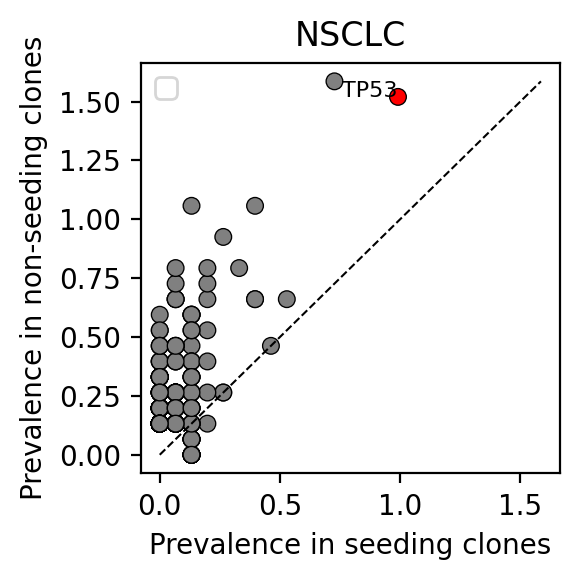

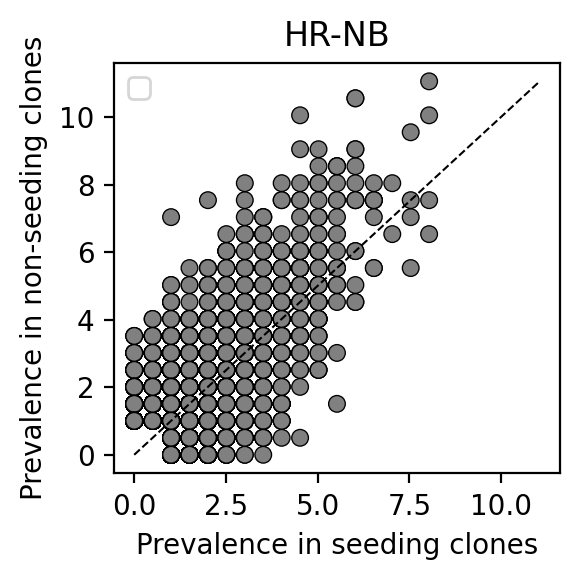

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


for dataset in ['NSCLC', "HR-NB"]:
    df = dataset_to_summary_dfs[dataset]
    # Create scatter plots
    plt.figure(figsize=(3,3), dpi=200)


    scatter = sns.scatterplot(data=df, x="Prevalence in seeding clones", y="Prevalence in non-seeding clones", hue='Significant',legend=False, palette={True: 'red', False: 'grey'}, edgecolor='k')

    # Annotate each point
    for i, row in df.iterrows():
        plt.annotate(row['Gene'], (row["Prevalence in seeding clones"], row["Prevalence in non-seeding clones"]), fontsize=8, ha='right')

   # Diagonal line
    m = max(df['Prevalence in seeding clones'].max(), df['Prevalence in non-seeding clones'].max())
    plt.plot([0, m], [0, m], 'k--', lw=0.75)

    # Axis labels and title
    plt.xlabel("Prevalence in seeding clones")
    plt.ylabel("Prevalence in non-seeding clones")
    plt.title(dataset)

    # Adding custom legend
    handles, labels = scatter.get_legend_handles_labels()
    legend_labels = ['q-value < 0.05' if lbl == 'True' else 'ns.' for lbl in labels]
    plt.legend(handles, legend_labels, loc='upper left')

    plt.tight_layout()
    plt.show()